In [1]:
%matplotlib inline

#### Import some stuff we'll use

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import json
import urllib2

# pm25rose.py needs to be in your directory
from pm25rose import WindroseAxes

 #### Customize matplotlib 
 See more here [http://matplotlib.org/users/customizing.html](http://matplotlib.org/users/customizing.html)

In [20]:
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [3.5, 3]
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [36]:
def MWdate_to_datetime(x):
    """
    Converts a MesoWest date string to a python datetime object
    So far only works for summer months (daylight savings time). Best if you
    make all your MesoWest API calls in UTC time.

    For fastest calculations, vectorize this function before using:
    Example:
        vectorized_convert_time_function = np.vectorize(MWdate_to_datetime)
        DATES = vectorized_convert_time_function(dates)

    As my personal notation:
        DATES = list or array of python datetime object
        dates = native dates format, typically a string or number in epoch time
    """

    try:
        # print 'Times are in UTC'
        return datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')

    except:
        # print 'Times are in Local Time'
        return datetime.strptime(x, '%Y-%m-%dT%H:%M:%S-0600')

In [37]:
token = '1234567890'

# String of some MesoWest variables available from this list:
# https://synopticlabs.org/api/mesonet/variables/
default_vars = 'altimeter,pressure,sea_level_pressure,wind_direction,\
wind_speed,air_temp,relative_humidity,dew_point_temperature,wind_gust'

def get_mesowest_ts(stationID, start_time, end_time, variables = default_vars, verbose=True):
    """
    Get MesoWest Time Series:
    Makes a time series query from the MesoWest API for a single station.

    Note: Put all print statements under "if verbose==True:" because some of my 
    cgi scripts cannot deal with printed statements.

    Input:
        stationID  : string of the station ID
        start_time : datetime object of the start time in UTC
        end_time   : datetime object of the end time in UTC
        verbose    : print out some diagnostics, defualt is True

    Output:
        A dictionary of the data.
    """

    # Convert the start and end time to the string format requried by the API
    start = start_time.strftime("%Y%m%d%H%M")
    end = end_time.strftime("%Y%m%d%H%M")
    tz = 'utc'  # This is hard coded for now. Local time could be added later.

    # The API request URL
    URL = 'http://api.mesowest.net/v2/stations/timeseries?&token=' + token \
        + '&stid=' + stationID \
        + '&start=' + start \
        + '&end=' + end \
        + '&vars=' + variables \
        + '&obtimezone=' + tz \
        + '&output=json'

    # Open URL and read JSON content. Convert JSON string to some python
    # readable format.
    f = urllib2.urlopen(URL)
    data = f.read()
    data = json.loads(data)

    # Store the data we will return in this new dictionary
    return_this = {}

    # Get basic station information
    return_this['URL'] = URL
    return_this['NAME'] = str(data['STATION'][0]['NAME'])
    return_this['STID'] = str(data['STATION'][0]['STID'])
    return_this['LAT'] = float(data['STATION'][0]['LATITUDE'])
    return_this['LON'] = float(data['STATION'][0]['LONGITUDE'])
    return_this['ELEVATION'] = float(data['STATION'][0]['ELEVATION'])
                                  # Note: Elevation is in feet, NOT METERS!


    # Dynamically create keys in the dictionary for each requested variable
    for v in data['STATION'][0]['SENSOR_VARIABLES'].keys():
        if v == 'date_time':
            # Dates: Convert the strings to a python datetime object.mro
            dates = data["STATION"][0]["OBSERVATIONS"]["date_time"]
            converttime = np.vectorize(MWdate_to_datetime)
            return_this['DATETIME'] = converttime(dates)

        else:
            # v represents all the variables, but each variable may have
            # more than one set.
            # For now, just return the first set.
            key_name = str(v)
            set_num = 0

            grab_this_set = str(data['STATION'][0]['SENSOR_VARIABLES']\
                                [key_name].keys()[set_num])

            # Always grab the first set (either _1 or _1d)
            # should make exceptions to this rule for certain stations and certain variables
            if grab_this_set[-1] != '1' and grab_this_set[-1] != 'd':
                grab_this_set = grab_this_set[0:-1]+'1'
            if grab_this_set[-1] == 'd':
                grab_this_set = grab_this_set[0:-2]+'1d'

            variable_data = np.array(data['STATION'][0]['OBSERVATIONS']\
                                    [grab_this_set], dtype=np.float)
            return_this[key_name] = variable_data


    return return_this

In [38]:
# Make Rose
#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(5, 10), facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax
#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    plt.setp(l.get_texts())
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), prop={'size':10})

In [44]:
def rose_with_labels():
    ax = new_axes()
    ax.bar(wd, ws,
           nsector=16,
           bins=[0, 12.1, 35.5, 55.5, 150.5],
           normed=True,
           colors=('green', 'yellow', 'orange', 'red', 'purple'))

    set_legend(ax)
    plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%H:%M UTC %d%b%Y'), end.strftime('%H:%M UTC %d%b%Y')))

    plt.grid(True)
    plt.yticks(np.arange(0, 105, 5))
    ax.set_yticklabels(['', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
    #ax.set_rmax(25)
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))
    plt.savefig(SAVE + "pm25rose.png")
    #plt.show()

In [45]:
def rose_no_labels():    
    """
    There is no grid or labels, just the colorbars.
    I like to overlay these on maps
    """
    ax = new_axes()
    ax.bar(wd, ws,
           nsector=16,
           bins=[0, 12.1, 35.5, 55.5, 150.5],
           normed=True,
           colors=('green', 'yellow', 'orange', 'red', 'purple'))

    #set_legend(ax)
    ax.axis('off')
    #ax.set_rmax(25)
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))
    plt.savefig(SAVE + "pm25rose_nolabel.png", transparent=True)
    #plt.show()

In [48]:
def clock_rose():
    """
    Creates an ozone rose clock and shows time of day each of the
    observations occur in rather than the direction. Top of plot
    is hour 0, bottom is hour 12.
    """
    # Make array of hours and convert it to a "degree" for
    # The polar plot (multiply the hour by 15 becuase 360degress/24hours == 15)
    hour = np.array([i.hour*15 for i in a['DATETIME']])

    ax = new_axes()
    ax.contourf(hour, ws,
                nsector=24,
                bins=[0, 12.1, 35.5, 55.5, 150.5],
                normed=True,
                colors=('green', 'yellow', 'orange', 'red', 'purple'))

    set_legend(ax)
    plt.title("PM2.5 Clock %s \n %s - %s \n" % (a['NAME'], start.strftime('%H:%M UTC %d%b%Y'), end.strftime('%H:%M UTC %d%b%Y')))

    plt.grid(True)
    plt.yticks(np.arange(0, 105, 5))
    ax.set_yticklabels(['', '', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
    ax.set_xticklabels(['06:00', '03:00', '00:00', '21:00', '18:00', '15:00', '12:00', '09:00'])

    # Maximum Radial Circle
    #ax.set_rmax(5)                                         # uncomment to unify all rmax
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))  # set rmax as the biggest arm

    plt.savefig(SAVE + "pm25rose_clock.png")
    #plt.show()
    #print np.sum(ax._info['table'],axis=0)

  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  axes: an :class:`~matplotlib.axes.Axes` instance 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a :class:`matplotlib.figure.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: string or anything printable with '%s' conversion. 
  linespacing: float (multiple of font size) 
  multialignment: 

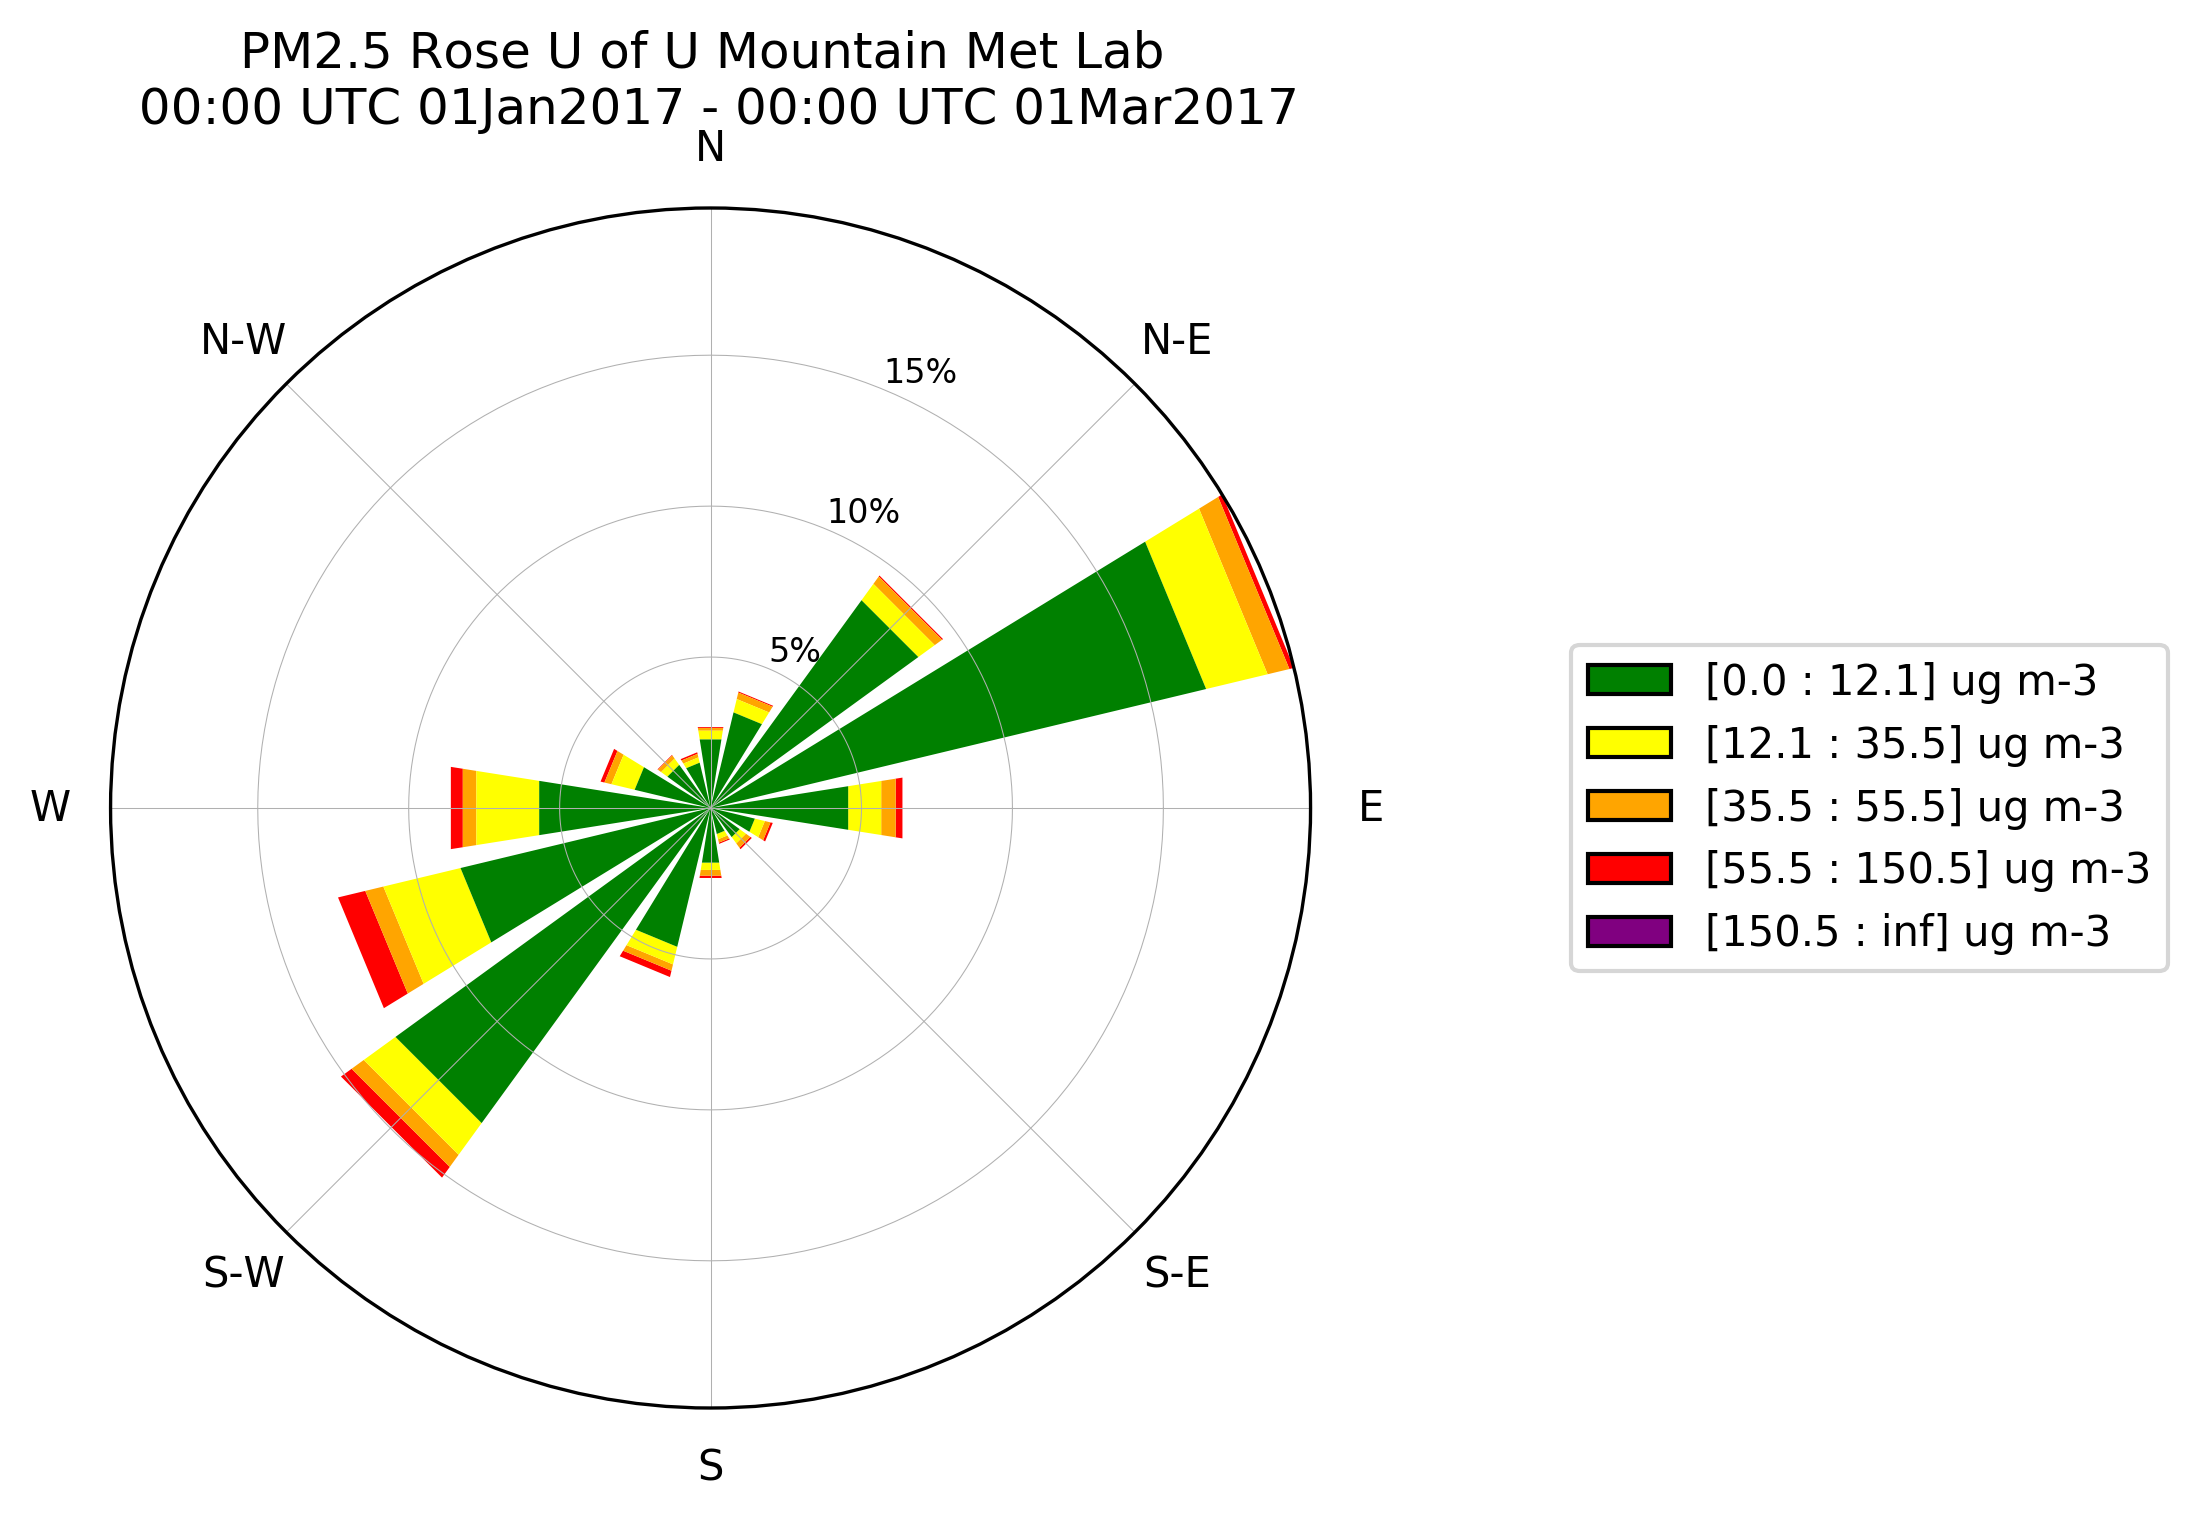

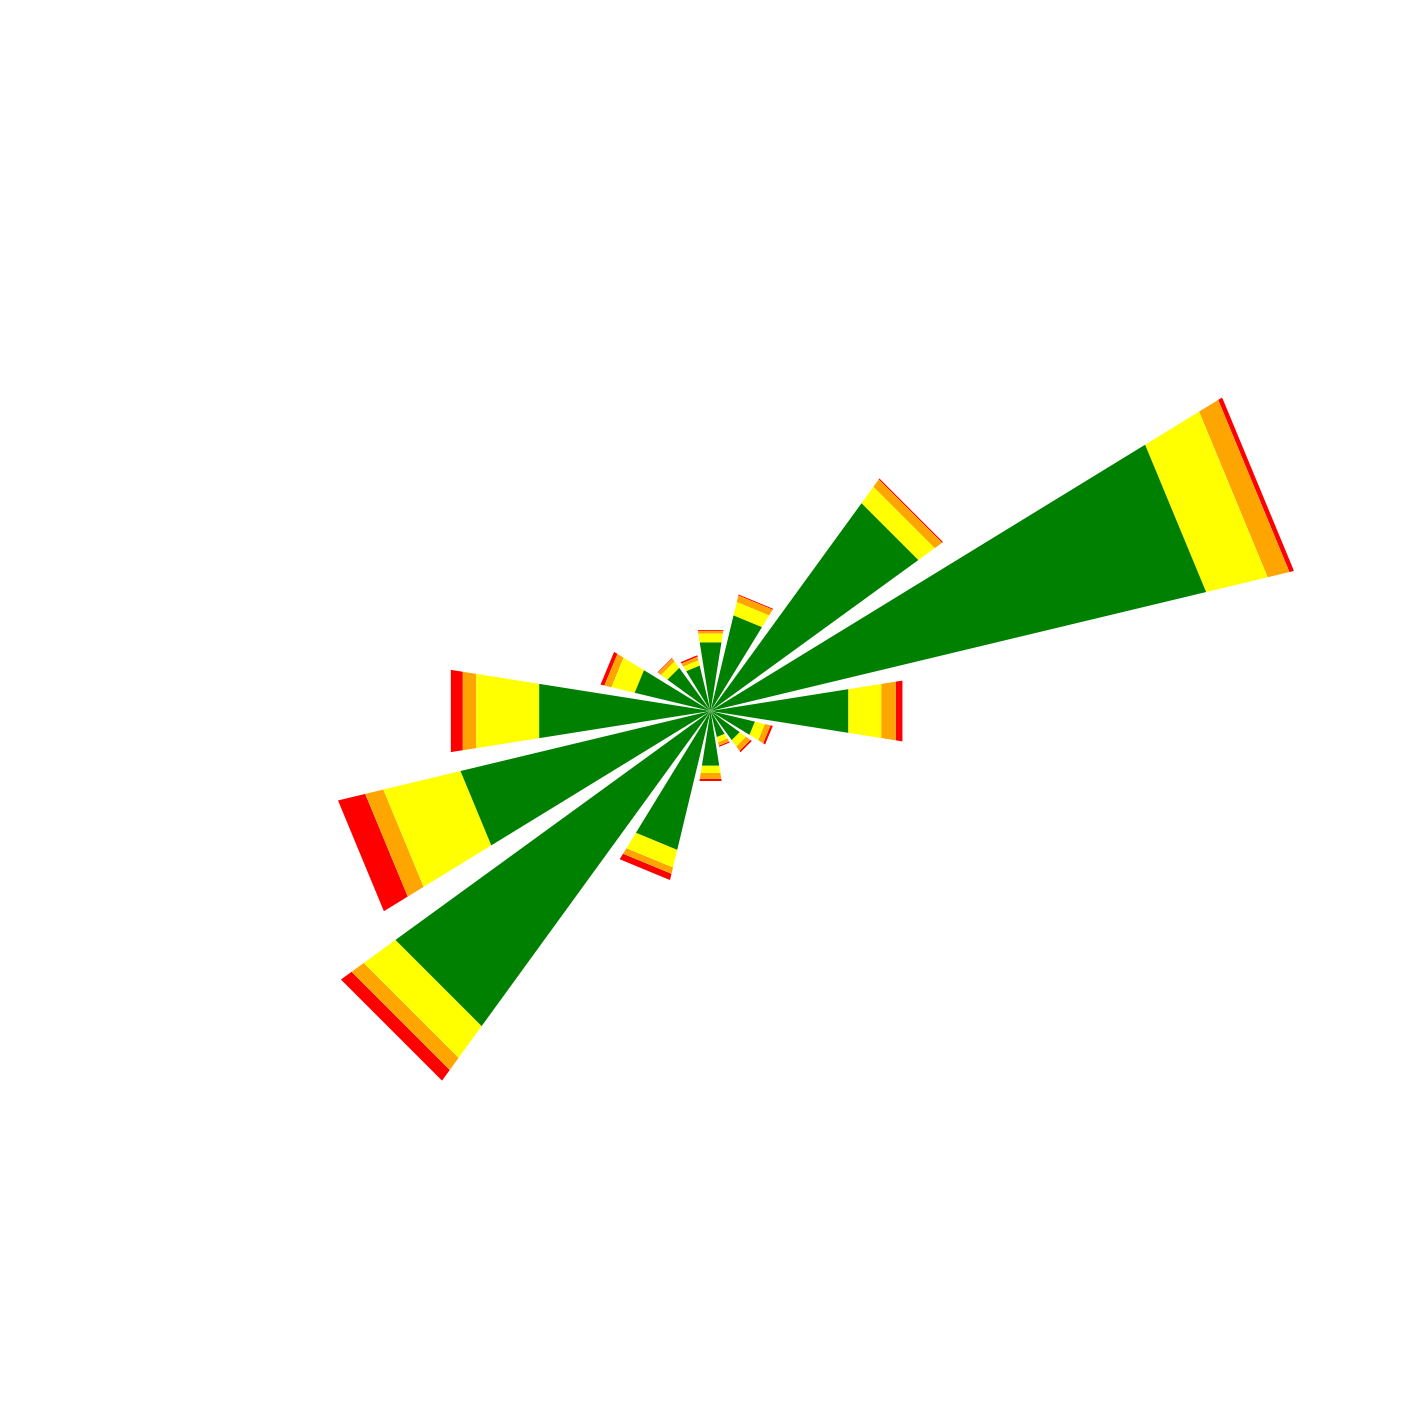

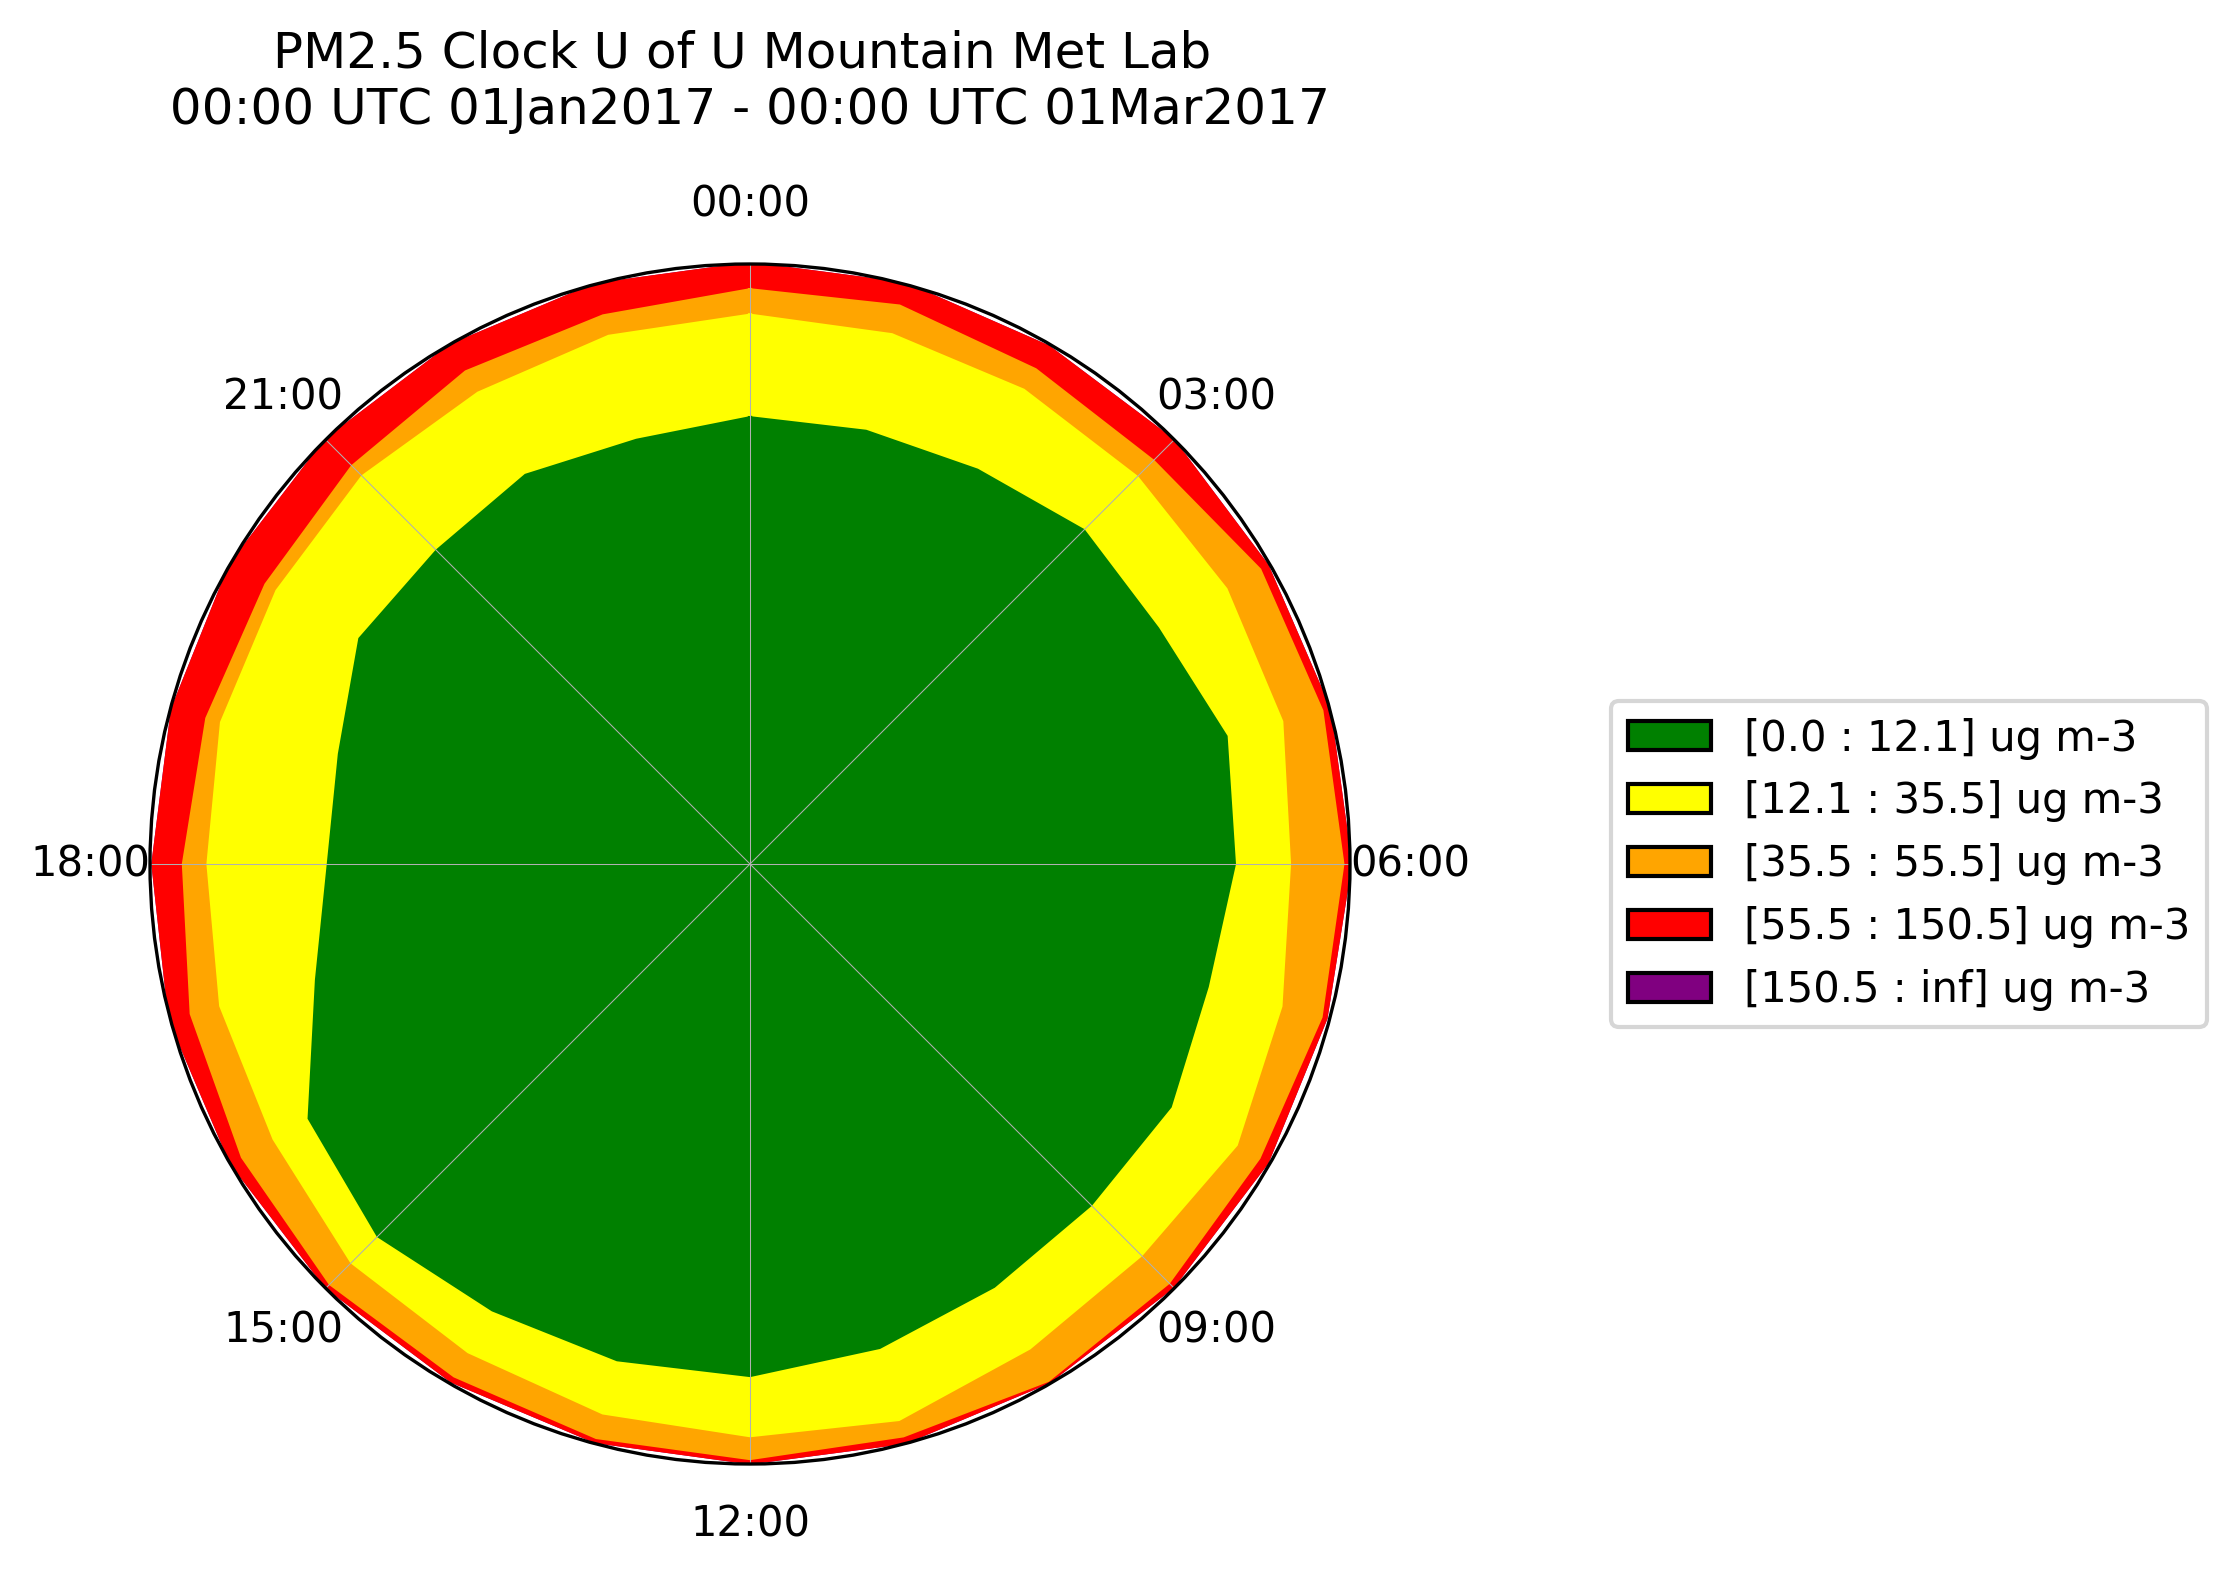

In [49]:
# Save directory
SAVE = "./"

# Date range for data
start = datetime(2016, 11, 1)
end = datetime(2017, 3, 1)

# MesoWest station ID
stn = 'MTMET'

# Get MesoWest Data
a = get_mesowest_ts(stn, start, end, variables='wind_direction,PM_25_concentration')

# Get data we want from the dictionary
wd = a['wind_direction']
ws = a['PM_25_concentration']

rose_with_labels()
rose_no_labels()
clock_rose()

SOME NOTES:  
to look at the values used to create the plot look at ax._info ax._info['table'] contains the frequency for each bin in each direction  
np.sum(ax._info['table'],axis=0) is the total frequency for each direction  
np.max(np.sum(ax._info['table'],axis=0)) is the maximum frequency I like to use to set my max radius.